### In this example, the distribution of MNIST dataset will be learn and generate new samples form it.

In [1]:
import numpy as np
import optax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from jax.tree_util import tree_map
from torch.utils import data
from functools import partial

from utils.sampling_utlis import ula
from utils.score_matching_utlis import score_matching_loss, sliced_score_matching_loss
from model.model import Score_MLP

### Get the dataset

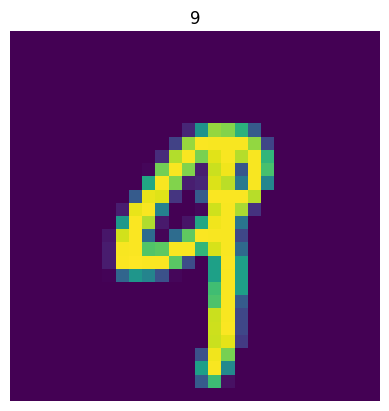

In [2]:
def visual_image(image, label=None):
    plt.figure()
    plt.imshow(image.reshape(28,28))
    if label:
        plt.title(label)
    plt.axis("off")

def numpy_collate(batch):
  return tree_map(np.asarray, data.default_collate(batch))

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndNormal(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32)) / 255
  
mnist_dataset = MNIST('./dataset', download=True, transform=FlattenAndNormal())
training_dataloader = NumpyLoader(mnist_dataset, batch_size=128, shuffle=True, drop_last=True)

images, labels = next(iter(training_dataloader))
visual_image(images[0], labels[0])
img_dim = images.shape[1]

### Learn the MNIST distribution

In [3]:
random_key = jax.random.PRNGKey(0)
model = Score_MLP(features=[128]*4, dim=img_dim)
random_key, key_to_use = jax.random.split(random_key)
model_param = model.init(key_to_use, images[0], 0)
optimizer = optax.adam(learning_rate=1e-3)
optimizer_state = optimizer.init(model_param)

score_matching_loss_wrapped = partial(sliced_score_matching_loss, model.apply)

In [4]:
@jax.jit
def params_update(param, optimizer_state, xs, random_key):
    ts = jnp.zeros(xs.shape[0])
    loss, grad = jax.value_and_grad(score_matching_loss_wrapped)(param, xs, ts, random_key)
    update, optimizer_state = optimizer.update(grad, optimizer_state, param)
    param = optax.apply_updates(param, update)
    return loss, param, optimizer_state

losses = []
for epoch in range(200):
    total_loss = 0
    # get a batch of data
    for i, (images, labels) in enumerate(training_dataloader):
    # one step grad update
        random_key, key_to_use = jax.random.split(random_key)
        loss, model_param, optimizer_state = params_update(model_param, optimizer_state, images, key_to_use)
        total_loss += loss
    
    losses.append(total_loss / len(training_dataloader))
    print(f"iter:{epoch+1}, loss:{losses[-1]}")

iter:1, loss:-3001.431396484375
iter:2, loss:-57652.43359375
iter:3, loss:-336931.09375
iter:4, loss:-979503.6875
iter:5, loss:-2002505.5
iter:6, loss:-3266862.75
iter:7, loss:-4714966.0
iter:8, loss:-7564846.0
iter:9, loss:-9844822.0
iter:10, loss:-12903512.0
iter:11, loss:-17790052.0
iter:12, loss:-23321154.0
iter:13, loss:-23918322.0
iter:14, loss:-35916744.0
iter:15, loss:-34965228.0
iter:16, loss:-30673120.0
iter:17, loss:-37776204.0
iter:18, loss:-56585264.0
iter:19, loss:-54854720.0
iter:20, loss:-64038104.0
iter:21, loss:-68561384.0
iter:22, loss:-66597020.0
iter:23, loss:-75052872.0
iter:24, loss:-78815504.0
iter:25, loss:-103130248.0
iter:26, loss:-140762992.0
iter:27, loss:-154167984.0
iter:28, loss:-176515312.0
iter:29, loss:-184078064.0
iter:30, loss:-200586368.0
iter:31, loss:-209441280.0
iter:32, loss:-236224160.0
iter:33, loss:-269777920.0
iter:34, loss:-169111296.0
iter:35, loss:-237925568.0
iter:36, loss:-223019952.0
iter:37, loss:-253958544.0
iter:38, loss:-287785888

[]

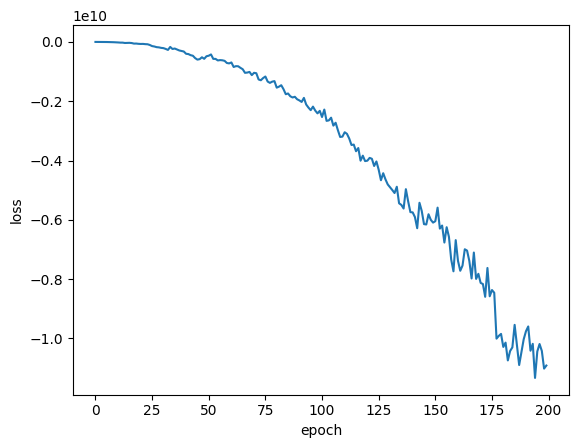

In [5]:
plt.figure()
plt.plot(losses, label="training loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot()

### Evaluate numerical stability
The score-matching loss tend to be very big numerically.
Here we try to evaluate the numerical value of **(model param) gradient**,and the **score value** in and out of distributions   

Here, we see simply run score-matching and Langevin dynamics lead to a very **big numerical value** for score even inside distribition. Moreover, after one-step Langevin dynamics, the update result is not a valid image anymore and the score function there is **very very big**, further drift the sample away.

In [22]:
# Numerical stability
loss, grad = jax.value_and_grad(score_matching_loss_wrapped)(model_param, images, np.zeros(images.shape[0]), random_key)

for layer in grad["params"]:

    kernel_max = jnp.max(jnp.abs(grad["params"][layer]["kernel"]))
    bias_max = jnp.max(jnp.abs(grad["params"][layer]["bias"]))
    print(f"Layer:{layer}, Kernel max:{kernel_max}, Bias max:{bias_max}")

print(f"Max score inside dist:{jnp.max(jnp.abs(model.apply(model_param, images[0], 0)))}")
images_after_one_step_LD = model.apply(model_param, images[0], 0) * 0.01 + images[0]
print(f"Image max-min after one step Langevin dynamics {np.max(images_after_one_step_LD)}, {np.min(images_after_one_step_LD)}" )
print(f"Max score out dist(use one step update image):{jnp.max(jnp.abs(model.apply(model_param, images_after_one_step_LD, 0)))}")

Layer:Dense_0, Kernel max:37345116160.0, Bias max:53889753088.0
Layer:Dense_1, Kernel max:15566918656.0, Bias max:7367414784.0
Layer:Dense_2, Kernel max:1758327424.0, Bias max:468232448.0
Layer:Dense_3, Kernel max:738068928.0, Bias max:7296307.0
Layer:Dense_4, Kernel max:6579706.0, Bias max:14264.08984375
Max score inside dist:8146.15771484375
Image max-min after one step Langevin dynamics 75.7485122680664, -81.46157836914062
Max score out dist(use one step update image):142246969344.0


### Generate sample use learned score function

The initial score function biggest entries 113972.53


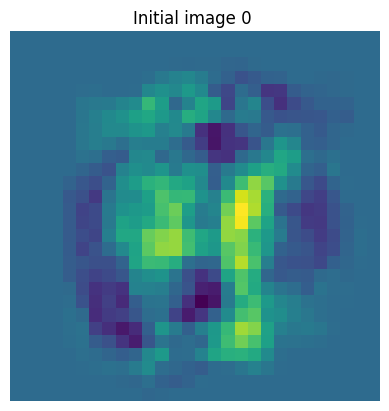

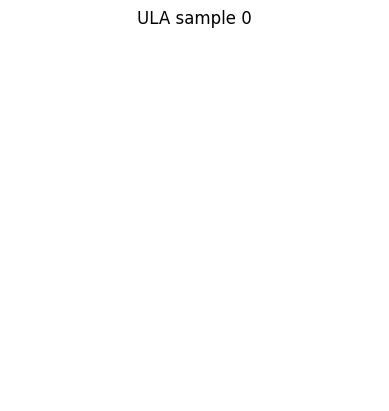

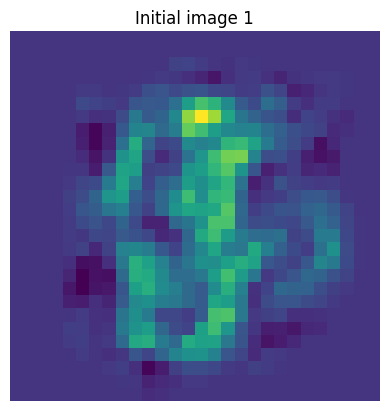

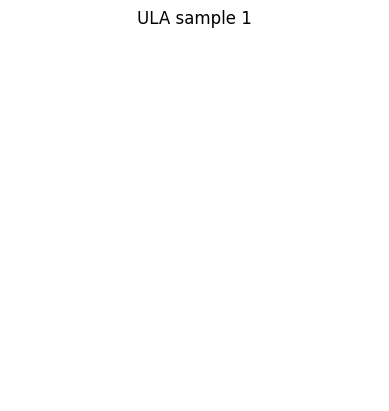

In [9]:
@jax.jit
def learned_score_fn(x, t):
    return model.apply(model_param, x, t)

random_key = jax.random.PRNGKey(0)

# use mean and cov calculate from samples to construct a Gaussian
x0s = np.random.multivariate_normal(mean=np.mean(images,axis=0), cov=np.cov(images, rowvar=False), size=2)
random_keys = jax.random.split(random_key, 2)

ula_wrapped = partial(ula, learned_score_fn, T=10, dt=0.01)

samples = jax.vmap(ula_wrapped)(x0s, random_keys)

print("The initial score function biggest entries", np.max(np.abs(learned_score_fn(x0s, np.array([0,0])))))

visual_image(x0s[0], label="Initial image 0 ")
visual_image(samples[0], label="ULA sample 0")
visual_image(x0s[1], label="Initial image 1")
visual_image(samples[1], label="ULA sample 1")